In [1]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers

In [2]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 



In [4]:
df = pd.read_csv('ddb_output.csv'
         ).rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},
         ).drop(columns=['Unnamed: 0']
         ).sort_values(by='timestamp')

In [5]:
fig = px.scatter(df, x="timestamp", y=["humidity","temperature"], title='All-time humidity and temperature in the grove!')
fig.show()

In [6]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['temperature'], name="Temperature", mode='markers'),
secondary_y=False,
)

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['humidity'], name="Humidity", mode='markers'),
secondary_y=True,
)

fig.update_layout(
title_text="Temperature and humidity over time"
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Temperature</b>", title_font_color='blue', secondary_y=False)
fig.update_yaxes(title_text="<b>Humidity</b>", title_font_color='red', secondary_y=True)

In [7]:
df['date'] = df['timestamp'].map(lambda x: pd.Timestamp(x).date())

In [8]:
df_last_week = df[df['timestamp'] > str(pd.Timestamp('2023-05-1'))]

In [9]:
fig = px.box(df_last_week, x="date", y="temperature")
fig.show()

## Building a forecasting model 

In [10]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')
df_temp.head()

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00


In [11]:
px.scatter(df_temp, x='timestamp', y='temperature', title='Temperature from 28 April to May 11th (~12 days)')

### Baseline - persistence forecast 1,2,4 hours in advance

In [12]:
df_temp

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00
...,...,...
3753,20.37,2023-05-22 10:10:00
3754,20.38,2023-05-22 10:20:00
3755,20.31,2023-05-22 10:30:00
3756,20.43,2023-05-22 10:40:00


In [13]:
# Test - to predict temperature 1,2,4 hours in advance

def persistence_n_hours(n):

    timestamps_n_hr = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x) + pd.Timedelta(hours=n))

    df_temp_n_hr_baseline = pd.DataFrame(list(zip(timestamps_n_hr,df_temp['temperature'])))
    df_temp_n_hr_baseline.rename(columns={0:'timestamp', 1:'value'},inplace=True)
    df_temp_n_hr_baseline['type'] = f'persist. {n}hrs'
    df_temp_n_hr_baseline = df_temp_n_hr_baseline[['value', 'timestamp', 'type']]
    df_temp_n_hr_baseline

    return df_temp_n_hr_baseline

persist_1_hr = persistence_n_hours(1)
persist_2_hr = persistence_n_hours(2)
persist_4_hr = persistence_n_hours(4)


In [14]:
df_temp['type'] = 'observation'
df_temp.rename(columns={'temperature':'value'},inplace=True)
df_temp

,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
3753,20.37,2023-05-22 10:10:00,observation
3754,20.38,2023-05-22 10:20:00,observation
3755,20.31,2023-05-22 10:30:00,observation
3756,20.43,2023-05-22 10:40:00,observation


In [15]:
df_1_hour_forecast = pd.concat([df_temp, persist_2_hr], axis=0)

df_1_hour_forecast['timestamp'] = df_1_hour_forecast['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_1_hour_forecast.sort_values(by='timestamp',inplace=True)

df_1_hour_forecast_1_day = df_1_hour_forecast[ df_1_hour_forecast['timestamp'] > str(pd.Timestamp('2023-05-10')) ]

df_1_hour_forecast


,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
3753,20.37,2023-05-22 12:10:00,persist. 2hrs
3754,20.38,2023-05-22 12:20:00,persist. 2hrs
3755,20.31,2023-05-22 12:30:00,persist. 2hrs
3756,20.43,2023-05-22 12:40:00,persist. 2hrs


In [16]:

px.scatter(df_1_hour_forecast_1_day, x='timestamp', y='value', color='type', title='Temperature from 28 April to May 11th (~12 days)')

In [17]:
df_1_hour_forecast['value'] = df_1_hour_forecast['value'].astype(float)

In [18]:
# This works but not where there's NaN

persistence_forecast_1_hr = df_1_hour_forecast.pivot_table(values='value', index='timestamp', columns='type').head(-20)
persistence_forecast_1_hr['rel_error'] = persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs']
persistence_forecast_1_hr['abs_error'] = abs(persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs'] )

persistence_forecast_1_hr

persistence_forecast_1_hr_errors = persistence_forecast_1_hr[['rel_error','abs_error']]
persistence_forecast_1_hr_errors.reset_index(inplace=True)

persistence_forecast_1_hr_errors = persistence_forecast_1_hr_errors.melt(id_vars='timestamp')
persistence_forecast_1_hr_errors

px.scatter(persistence_forecast_1_hr_errors, x='timestamp', y='value', color='type', title='Errors from a 1-hr persistence forecast')

In [19]:
persistence_forecast_1_hr_errors

,timestamp,type,value
0,2023-04-28 08:25:00,rel_error,NaN
1,2023-04-28 08:30:00,rel_error,NaN
2,2023-04-28 09:20:00,rel_error,NaN
3,2023-04-28 09:30:00,rel_error,NaN
4,2023-04-28 09:40:00,rel_error,NaN
...,...,...,...
7511,2023-05-22 08:50:00,abs_error,0.17
7512,2023-05-22 09:00:00,abs_error,0.03
7513,2023-05-22 09:10:00,abs_error,0.12
7514,2023-05-22 09:20:00,abs_error,0.16


In [20]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp.set_index('timestamp',inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-22 10:10:00,20.37
2023-05-22 10:20:00,20.38
2023-05-22 10:30:00,20.31


In [21]:
df_temp.dropna(inplace=True)

# Some quick code to set this up: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

In [22]:
!

In [23]:
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


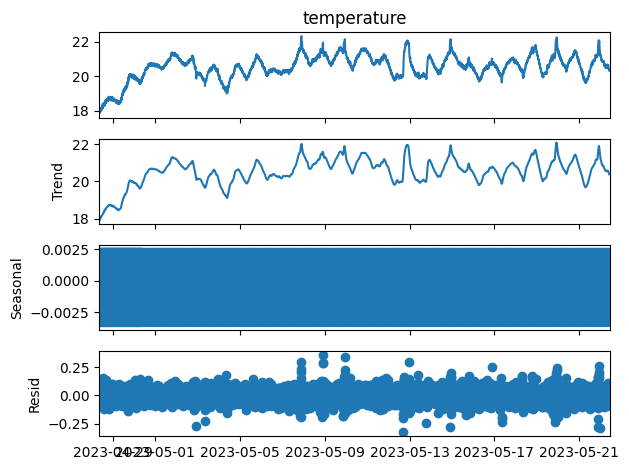

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

results = seasonal_decompose(df_temp['temperature'], period=10)
results.plot()
pyplot.show()

In [25]:
temp_array = df_temp['temperature'][0:100].values
temp_array

array([17.83, 17.85, 17.85, 17.88, 17.88, 17.97, 17.92, 17.99, 17.95,
       18.01, 18.01, 17.97, 17.97, 17.95, 17.97, 18.06, 18.15, 18.06,
       18.11, 18.16, 18.05, 18.11, 18.15, 18.09, 18.08, 18.19, 18.12,
       18.05, 18.12, 18.06, 18.19, 18.16, 18.15, 18.11, 18.22, 18.24,
       18.11, 18.18, 18.15, 18.21, 18.21, 18.22, 18.13, 18.22, 18.39,
       18.22, 18.32, 18.26, 18.21, 18.19, 18.28, 18.28, 18.35, 18.29,
       18.32, 18.39, 18.28, 18.39, 18.34, 18.31, 18.42, 18.39, 18.31,
       18.39, 18.39, 18.38, 18.46, 18.28, 18.4 , 18.42, 18.45, 18.45,
       18.47, 18.5 , 18.52, 18.52, 18.55, 18.39, 18.43, 18.42, 18.53,
       18.53, 18.62, 18.45, 18.47, 18.49, 18.46, 18.52, 18.55, 18.59,
       18.49, 18.55, 18.6 , 18.57, 18.52, 18.59, 18.66, 18.67, 18.6 ,
       18.6 ])